## <span style="color: blue;">1️⃣ <b><u>Import Libraries</u></b> </span>

In [432]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
import pandas as pd
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import GOOG
from pandas_datareader import data as web
import talib

import warnings
warnings.filterwarnings('ignore')

## <span style="color: green;">2️⃣ <b><u>Pull Data From Yahoo Finance</u></b></span>

In [434]:
# Define the function to get stock data
def get_stock_data(ticker, start_date, end_date, interval):
    df = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    df.dropna(inplace=True)
    
    # Drop the 'Adj Close' column if it exists
    if 'Adj Close' in df.columns:
        df.drop(columns=['Adj Close'], inplace=True)
    
    # Ensure single-level column names
    df.columns = df.columns.get_level_values(0)  # Flatten columns
    df.columns.name = None  # Remove the name attribute from columns

    # Reset index to include Date column
    df.reset_index(inplace=True)
    df.set_index('Date', inplace=True)
    
    # Ensure columns are in correct order
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    
    return df

## 3️⃣ <span style="color: red;"><b><u>Trading Strategies</u></b></span>

In [446]:
# List of stocks (holdings of FBGRX)
holdings = ['MSFT', 'AAPL', 'AMZN', 'GOOGL', 'META']

# Define the time period
start_date = '2010-01-01'
end_date = '2023-12-31'

cash_in_hand = 10000
brokerage = .002

### <b> 1. </b> Moving Average Ribbon Strategy [Parv]

In [54]:
def moving_average_ribbon_strategy(df):
    short_window = 10
    long_window = 50
    df['Short_MA'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window, min_periods=1).mean()
    
    df['Signal'] = 0
    df['Signal'][short_window:] = np.where(df['Short_MA'][short_window:] > df['Long_MA'][short_window:], 1, 0)
    
    return df

### <b> 2. </b> SuperTrend Strategy [Parv]

In [52]:
def supertrend_strategy(df, atr_period=7, multiplier=3):
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    tr = pd.DataFrame([high_low, high_close, low_close]).max(axis=0)
    atr = tr.rolling(atr_period).mean()
    
    df['Upper_Band'] = (df['High'] + df['Low']) / 2 + (multiplier * atr)
    df['Lower_Band'] = (df['High'] + df['Low']) / 2 - (multiplier * atr)
    df['Supertrend'] = np.nan
    
    for i in range(1, len(df)):
        if df['Close'][i] > df['Upper_Band'][i - 1]:
            df['Supertrend'][i] = df['Lower_Band'][i]
        elif df['Close'][i] < df['Lower_Band'][i - 1]:
            df['Supertrend'][i] = df['Upper_Band'][i]
        else:
            df['Supertrend'][i] = df['Supertrend'][i - 1]
    
    df['Signal'] = np.where(df['Close'] > df['Supertrend'], 1, 0)
    
    return df

### <b> 3. </b> Volatility Breakout Strategy [Parv]

In [ ]:
def volatility_breakout_strategy(df, lookback=20, multiplier=2):
    df['High_Max'] = df['High'].rolling(lookback).max()
    df['Low_Min'] = df['Low'].rolling(lookback).min()
    df['Range'] = df['High_Max'] - df['Low_Min']
    
    df['Buy_Level'] = df['Open'] + (multiplier * df['Range'].shift())
    df['Sell_Level'] = df['Open'] - (multiplier * df['Range'].shift())
    
    df['Signal'] = 0
    df['Signal'] = np.where(df['Close'] > df['Buy_Level'], 1, df['Signal'])
    df['Signal'] = np.where(df['Close'] < df['Sell_Level'], -1, df['Signal'])
    
    return df

### <b> 4. </b> Money Flow Index (MFI) Strategy [Anand]

In [61]:
def mfi_strategy(df, period=14):
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    money_flow = typical_price * df['Volume']
    
    positive_flow = money_flow.copy()
    negative_flow = money_flow.copy()
    
    positive_flow[typical_price < typical_price.shift(1)] = 0
    negative_flow[typical_price > typical_price.shift(1)] = 0
    
    positive_mf = positive_flow.rolling(period).sum()
    negative_mf = negative_flow.rolling(period).sum()
    
    mfi = 100 - (100 / (1 + (positive_mf / negative_mf)))
    df['MFI'] = mfi
    
    df['Signal'] = 0
    df['Signal'] = np.where(df['MFI'] < 20, 1, df['Signal'])
    df['Signal'] = np.where(df['MFI'] > 80, -1, df['Signal'])
    
    return df

### <b> 5. </b> Volume Price Trend (VPT) Strategy [Anand]

In [64]:
def vpt_strategy(df):
    vpt = ((df['Close'].pct_change() + 1).cumprod() - 1) * df['Volume']
    df['VPT'] = vpt.cumsum()
    
    df['Signal'] = 0
    df['Signal'] = np.where(df['VPT'] > df['VPT'].shift(), 1, 0)
    
    return df

### <b> 6. </b> Heikin-Ashi Candlesticks Strategy [Anand]

In [67]:
def heikin_ashi_strategy(df):
    ha_df = df.copy()
    ha_df['Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
    ha_df['Open'] = (df['Open'].shift() + df['Close'].shift()) / 2
    ha_df['High'] = df[['Open', 'Close', 'High']].max(axis=1)
    ha_df['Low'] = df[['Open', 'Close', 'Low']].min(axis=1)
    
    df['HA_Close'] = ha_df['Close']
    df['HA_Open'] = ha_df['Open']
    
    df['Signal'] = 0
    df['Signal'] = np.where(df['HA_Close'] > df['HA_Open'], 1, df['Signal'])
    df['Signal'] = np.where(df['HA_Close'] < df['HA_Open'], -1, df['Signal'])
    
    return df

### <b> 7. </b> Renko Chart Strategy [Neel] - BUG 🔴

In [455]:
def calculate_renko(df, brick_size):
    df['Direction'] = None
    df['Renko'] = None
    for i in range(1, len(df)):
        if df['Close'][i] >= df['Close'][i-1] + brick_size:
            df.loc[df.index[i], 'Direction'] = 'Up'
            df.loc[df.index[i], 'Renko'] = df['Close'][i-1] + brick_size
        elif df['Close'][i] <= df['Close'][i-1] - brick_size:
            df.loc[df.index[i], 'Direction'] = 'Down'
            df.loc[df.index[i], 'Renko'] = df['Close'][i-1] - brick_size
    df.dropna(inplace=True)
    return df[['Renko']]

class RenkoStrategy(Strategy):
    brick_size = 2  # Define the size of the Renko bricks

    def init(self):
        # Use the pre-calculated renko data
        close_prices = self.data.Close
        self.renko = calculate_renko(pd.DataFrame({'Close': close_prices}), brick_size=self.brick_size)['Renko'].values

    def next(self):
        # Ensure Renko bricks are calculated
        if len(self.renko) < 2 or np.isnan(self.renko[-1]) or np.isnan(self.renko[-2]):
            return

        # Prevent selling if no position is held
        if not self.position and self.renko[-1] < self.renko[-2]:
            # print("Ignoring sell signal because no position is held")
            return

        # Simple trading logic based on Renko bricks
        # Buy when a new Renko brick is formed upwards
        # Sell when a new Renko brick is formed downwards
        if self.renko[-1] > self.renko[-2]:
            print("Buying")
            self.buy()
        elif self.renko[-1] < self.renko[-2]:
            print("Selling")
            self.sell()

# Example usage with sample data
ticker = 'AAPL'

# Download historical data for backtesting
df = get_stock_data(ticker, start_date, end_date, '1d')

# Backtest the strategy
bt = Backtest(df, RenkoStrategy, cash=cash_in_hand, commission=brokerage)
stats = bt.run()
print(stats)
#bt.plot()

[*********************100%***********************]  1 of 1 completed


Start                     2010-01-04 00:00:00
End                       2023-12-29 00:00:00
Duration                   5107 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]             2418.966407
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

### <b> 8. </b> Mean Reversion with Bollinger Bands and RSI Strategy [Neel] 🟢

In [450]:
class MeanReversionBBandRSI(Strategy):
    bb_window = 20
    rsi_window = 14
    upper_bb = 2
    lower_bb = 2

    def init(self):
        # Calculate Bollinger Bands
        close_prices = self.data.Close
        self.upper_band, self.middle_band, self.lower_band = self.I(talib.BBANDS, close_prices, timeperiod=self.bb_window, nbdevup=self.upper_bb, nbdevdn=self.lower_bb)
        
        # Calculate RSI
        self.rsi = self.I(talib.RSI, close_prices, timeperiod=self.rsi_window)

    def next(self):
        # Ensure that both Bollinger Bands and RSI are valid before proceeding
        if np.isnan(self.upper_band[-1]) or np.isnan(self.lower_band[-1]) or np.isnan(self.rsi[-1]):
            return

        # Prevent selling if no position is held
        if not self.position and self.data.Close[-1] > self.upper_band[-1] and self.rsi[-1] > 70:
            # print("Ignoring sell signal because no position is held")
            return

        # Trading logic based on Bollinger Bands and RSI
        if self.data.Close[-1] < self.lower_band[-1] and self.rsi[-1] < 30:
            # print("Buying")
            self.buy()
        elif self.data.Close[-1] > self.upper_band[-1] and self.rsi[-1] > 70:
            # print("Selling")
            self.sell()

# Create a DataFrame to store yearly returns for each stock for MeanReversionBBandRSI strategy
yearly_returns_df_2 = pd.DataFrame()

# Apply the MeanReversionBBandRSI strategy to each stock and calculate yearly returns
for ticker in holdings:
    print(f"\nBacktesting strategy for {ticker} using MeanReversionBBandRSI")
    
    # Download historical data for backtesting
    df = get_stock_data(ticker, start_date, end_date, '1d')
    
    # Backtest the strategy
    bt = Backtest(df, MeanReversionBBandRSI, cash=cash_in_hand, commission=brokerage)
    stats = bt.run()
    
    # Extract the equity curve and calculate yearly returns
    equity_curve = stats['_equity_curve']['Equity']
    yearly_returns = equity_curve.resample('Y').last().pct_change().dropna() * 100
    
    # Ensure the DataFrame has all years from start_date to end_date
    all_years = pd.date_range(start=start_date, end=end_date, freq='Y')
    yearly_returns = yearly_returns.reindex(all_years, fill_value=0)
    
    yearly_returns_df_2[ticker] = yearly_returns.values

# Calculate the average yearly returns across all stocks for MeanReversionBBandRSI strategy
average_yearly_returns_2 = yearly_returns_df_2.mean(axis=1)

# Create a DataFrame with "Date" and "Average Yearly Returns (%)"
average_yearly_returns_df_2 = pd.DataFrame({
    'Date': yearly_returns_df_2.index,
    'Average Yearly Returns (%)': average_yearly_returns_2
})

# Print the DataFrame
print(average_yearly_returns_df_2)

[*********************100%***********************]  1 of 1 completed


Backtesting strategy for MSFT using MeanReversionBBandRSI



[*********************100%***********************]  1 of 1 completed


Backtesting strategy for AAPL using MeanReversionBBandRSI



[*********************100%***********************]  1 of 1 completed


Backtesting strategy for AMZN using MeanReversionBBandRSI

Backtesting strategy for GOOGL using MeanReversionBBandRSI



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Backtesting strategy for META using MeanReversionBBandRSI
    Date  Average Yearly Returns (%)
0      0                    0.000000
1      1                   -0.415635
2      2                    9.672726
3      3                   53.600253
4      4                   15.406386
5      5                   42.661849
6      6                    8.951584
7      7                   45.199480
8      8                    2.775347
9      9                   49.832407
10    10                   52.392988
11    11                   35.165974
12    12                  -41.687397
13    13                   88.953022


### <b> 9. </b> Dual Moving Average Strategy [Neel] 🟢

In [480]:
class DualMovingAverage(Strategy):
    short_window = 50
    long_window = 200

    def init(self):
        close_prices = self.data.Close
        self.short_ma = self.I(talib.SMA, close_prices, timeperiod=self.short_window)
        self.long_ma = self.I(talib.SMA, close_prices, timeperiod=self.long_window)

    def next(self):
        if np.isnan(self.short_ma[-1]) or np.isnan(self.long_ma[-1]):
            return

        # Prevent selling if there are no positions to sell
        if not self.position and crossover(self.long_ma, self.short_ma):
            # print("Ignoring sell signal because no position is held")
            return

        if crossover(self.short_ma, self.long_ma):
            # print("Buying")
            self.buy()
        elif crossover(self.long_ma, self.short_ma):
            # print("Selling")
            self.sell()
            
# Create a DataFrame to store yearly returns for each stock
yearly_returns_df = pd.DataFrame()

# Apply the strategy to each stock and calculate yearly returns
for ticker in holdings:
    #print(f"\nBacktesting strategy for {ticker}")
    
    # Download historical data for backtesting
    df = get_stock_data(ticker, start_date, end_date, '1d')
    
    # Backtest the strategy
    bt = Backtest(df, DualMovingAverage, cash=cash_in_hand, commission=brokerage)
    stats = bt.run()
    
    # Extract the equity curve and calculate yearly returns
    equity_curve = stats['_equity_curve']['Equity']
    yearly_returns = equity_curve.resample('Y').last().pct_change().dropna() * 100
    
    # Ensure the DataFrame has all years from start_date to end_date
    all_years = pd.date_range(start=start_date, end=end_date, freq='Y')
    yearly_returns = yearly_returns.reindex(all_years, fill_value=0)
    
    yearly_returns_df[ticker] = yearly_returns.values

# Calculate the average yearly returns across all stocks
average_yearly_returns = yearly_returns_df.mean(axis=1)

# Create a DataFrame with "Date" and "Average Yearly Returns (%)"
average_yearly_returns_df_1 = pd.DataFrame({
    'Date': yearly_returns_df.index,
    'Average Yearly Returns (%)': average_yearly_returns
})

# Plot the average yearly returns
# plt.figure(figsize=(10, 6))
# average_yearly_returns_df_1.plot(x='Date', y='Average Yearly Returns (%)', kind='bar', title="Average Yearly Performance of Holdings in FBGRX", color='skyblue')
# plt.xlabel("Year")
# plt.ylabel("Average Yearly Return (%)")
# plt.show()

# Print the DataFrame
print(average_yearly_returns_df_1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


    Date  Average Yearly Returns (%)
0      0                    0.000000
1      1                    0.353620
2      2                    4.727065
3      3                   43.198191
4      4                   15.402299
5      5                   42.640870
6      6                    8.948171
7      7                   45.188422
8      8                    2.771133
9      9                   49.824177
10    10                   52.387181
11    11                   35.162610
12    12                  -41.686132
13    13                   88.953962


## <span style="color: brown;">4️⃣ <u><b>Comparing with TD Mutual Fund</b></u></span>

In [482]:
# Define the mutual fund ticker
mutual_fund_ticker = 'FBGRX'  # Fidelity Blue Chip Growth Fund

# Create a Ticker object
mutual_fund = yf.Ticker(mutual_fund_ticker)

In [484]:
historical_data = mutual_fund.history(start=start_date, end=end_date)

# Resample data to get yearly data
yearly_data = historical_data['Close'].resample('Y').last()
mutual_fund_yearly_returns = yearly_data.pct_change().fillna(0) * 100

print(mutual_fund_yearly_returns)

Date
2010-12-31 00:00:00-05:00     0.000000
2011-12-31 00:00:00-05:00    -2.824663
2012-12-31 00:00:00-05:00    17.750631
2013-12-31 00:00:00-05:00    39.848323
2014-12-31 00:00:00-05:00    14.617588
2015-12-31 00:00:00-05:00     6.316555
2016-12-31 00:00:00-05:00     1.597576
2017-12-31 00:00:00-05:00    36.092880
2018-12-31 00:00:00-05:00     1.017671
2019-12-31 00:00:00-05:00    33.427740
2020-12-31 00:00:00-05:00    62.198221
2021-12-31 00:00:00-05:00    22.638959
2022-12-31 00:00:00-05:00   -38.449665
2023-12-31 00:00:00-05:00    55.608406
Freq: YE-DEC, Name: Close, dtype: float64


<Figure size 1200x800 with 0 Axes>

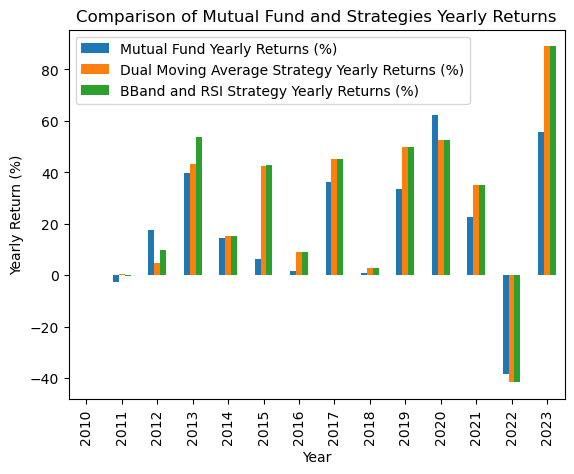

In [472]:
# Merge data for comparison
comparison_df = pd.DataFrame({
    'Date': mutual_fund_yearly_returns.index.year,
    'Mutual Fund Yearly Returns (%)': mutual_fund_yearly_returns.values,
    'Dual Moving Average Strategy Yearly Returns (%)': average_yearly_returns_df_1['Average Yearly Returns (%)'].values,
    'BBand and RSI Strategy Yearly Returns (%)': average_yearly_returns_df_2['Average Yearly Returns (%)'].values
})

# Plot the comparison
plt.figure(figsize=(12, 8))
comparison_df.set_index('Date').plot(kind='bar', title="Comparison of Mutual Fund and Strategies Yearly Returns")
plt.xlabel("Year")
plt.ylabel("Yearly Return (%)")
plt.legend(loc='best')
plt.show()

# Print the DataFrame
# print(comparison_df)